# Min GHG-C80

In [1]:
import swolfpy as sp
import swolfpy_inputdata as spid
import swolfpy_processmodels as sppm

import brightway2 as bw2
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import datetime
import os
import platform
from IPython.display import Image

# Set font for plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "14"

# Set specs for pandas
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.set_option("precision", 2)

### SwolfPy version used to produced the results:

In [2]:
pd.DataFrame({'Version': [sp.__version__, sppm.__version__, spid.__version__]},
             index=['swolfpy', 'swolfpy_processmodels', 'swolfpy_inputdata'])

,Version
swolfpy,0.2.4
swolfpy_processmodels,0.1.9
swolfpy_inputdata,0.2.4


### System info

In [3]:
pd.DataFrame({'info': [platform.platform(),
                       platform.processor(),
                       os.cpu_count()]},
             index=['Platform', 'Processor', 'CPU_count'])

,info
Platform,Windows-10-10.0.19041-SP0
Processor,"Intel64 Family 6 Model 158 Stepping 9, GenuineIntel"
CPU_count,8


## Setup

In [4]:
iter_mehtod = 'LHS' 
n_iter = 50
n_proc = os.cpu_count()
timeout = 700

method = ('IPCC 2013, Ecoinvent V3.5', 'climate change', 'GWP 100a, bioCO2=1, C1_36')

TotCost_Method = ('SwolfPy_Total_Cost', 'SwolfPy')
OptCost_Method = ('SwolfPy_Operational_Cost', 'SwolfPy')
CapCost_Method = ('SwolfPy_Capital_Cost', 'SwolfPy')
GWP_Method = ('IPCC 2013, Ecoinvent V3.5', 'climate change', 'GWP 100a, bioCO2=1, C1_36')
CED_Method = ('cumulative energy demand', 'fossil', 'non-renewable energy resources, fossil')
ACID_Method = ('TRACI (2.1) SwolfPy', 'environmental impact', 'acidification')
ETP_Method = ('TRACI (2.1) SwolfPy', 'environmental impact', 'eutrophication')
SMOG_Method = ('TRACI (2.1) SwolfPy', 'environmental impact', 'photochemical smog')
ETOX_Method = ('USEtox (obsolete)', 'ecotoxicity', 'total')
HTOX_Method = ('USEtox (obsolete)', 'human toxicity', 'total')

summary = f"""
********  Config *********
Time: {datetime.datetime.now().strftime("%Y-%m-%d & %H:%M:%S")}
Initial guess generation: {iter_mehtod}
N iter: {n_iter}
N proc: {n_proc}
timeout: {timeout}\n
"""
text_file = open("Summary.txt", "a")
text_file.write(summary)
text_file.close()

## Create project

In [5]:
project_name = 'optimization'
technosphere = sp.Technosphere(project_name)
common_data = spid.CommonData()
ProcessMetaData = sppm.ProcessModelsMetaData.ProcessModelsMetaData

In [6]:
# Treatment processes
Treatment_processes = {}
Treatment_processes['LF'] = {'input_type':ProcessMetaData['LF']['InputType'] , 'model':sppm.LF()}
Treatment_processes['Composting'] = {'input_type':ProcessMetaData['Comp']['InputType'] , 'model':sppm.Comp()}
Treatment_processes['AD'] = {'input_type':ProcessMetaData['AD']['InputType'] , 'model':sppm.AD()}
Treatment_processes['AnF'] = {'input_type':ProcessMetaData['AnF']['InputType'] , 'model':sppm.AnF()}
Treatment_processes['SS_MRF'] = {'input_type':ProcessMetaData['SS_MRF']['InputType'] , 'model':sppm.SS_MRF()}
Treatment_processes['Reprocessing'] = {'input_type':ProcessMetaData['Reproc']['InputType'] , 'model':sppm.Reproc()}
Treatment_processes['RDF'] = {'input_type':ProcessMetaData['RDF']['InputType'] , 'model':sppm.RDF()}
Treatment_processes['GC'] = {'input_type':ProcessMetaData['GC']['InputType'] , 'model':sppm.GC()}
Treatment_processes['WTE'] = {'input_type':ProcessMetaData['WTE']['InputType'] , 'model':sppm.WTE()}
Treatment_processes['Reprocessing'] = {'input_type':ProcessMetaData['Reproc']['InputType'] , 'model':sppm.Reproc()}

In [7]:
# Distance
Processes = ['LF', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing', 'RDF', 'GC', 'WTE', 'SF', 'MF', 'COM']
data = sppm.Distance.create_distance_table(process_names=Processes,
                                           transport_modes=['Heavy Duty Truck'],
                                           default_dist=30)

distance = sppm.Distance(data)          
data['Heavy Duty Truck']

,LF,Composting,AD,AnF,SS_MRF,Reprocessing,RDF,GC,WTE,SF,MF,COM
LF,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
Composting,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
AD,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
AnF,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
SS_MRF,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0
Reprocessing,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0
RDF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0
GC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0
WTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0
SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0


In [8]:
# Collection_processes:
Collection_processes = {}

SF_scheme = sppm.SF_Col.scheme()
SF_scheme[('RWC', 'SSO', 'SSR')] = 0.333
SF_scheme[('RWC', 'SSYW', 'SSR')] = 0.334
SF_scheme[('RWC', 'N/A', 'SSR')] = 0.333
Collection_processes['SF'] = {'input_type': [],
                              'model': sppm.SF_Col('SF', SF_scheme,
                              Treatment_processes=Treatment_processes,
                              Distance=distance)}

MF_scheme = sppm.MF_Col.scheme()
MF_scheme[('RWC', 'SSO', 'SSR')] = 0.333
MF_scheme[('RWC', 'SSYW', 'SSR')] = 0.334
MF_scheme[('RWC', 'N/A', 'SSR')] = 0.333
Collection_processes['MF'] = {'input_type': [],
                              'model': sppm.MF_Col('MF', MF_scheme,
                              Treatment_processes=Treatment_processes,
                              Distance=distance)}

COM_scheme = sppm.COM_Col.scheme()
COM_scheme[('RWC', 'N/A', 'SSR')] = 0.25
COM_scheme[('RWC', 'SSYW', 'SSR')] = 0.25
COM_scheme[('RWC', 'SSO', 'SSR')] = 0.25
COM_scheme[('RWC', 'SSO_AnF', 'SSR')] = 0.25
Collection_processes['COM'] = {'input_type': [],
                               'model': sppm.COM_Col('COM', COM_scheme,
                               Treatment_processes=Treatment_processes,
                               Distance=distance)}

In [9]:
population = 10**6
SF_density = 2.66
MF_density = 2.06
MF_fraction = 0.25
res_gen_rate = 1.12

# Composition data
comp_data = pd.read_csv('Composition Data/Updated Composition.csv', index_col=0)

# Set SF
Collection_processes['SF']['model'].process_data['Comp'] = comp_data['SingleFamily'].values
Collection_processes['SF']['model'].InputData.Col['res_per_dwel']['amount'] = SF_density
Collection_processes['SF']['model'].InputData.Col['houses_res']['amount'] = population * (1-MF_fraction) / SF_density
Collection_processes['SF']['model'].InputData.Col['res_gen']['amount'] = res_gen_rate

# Set MF
Collection_processes['MF']['model'].process_data['Comp'] = comp_data['MultiFamily'].values
Collection_processes['MF']['model'].InputData.Col['res_per_dwel']['amount'] = MF_density
Collection_processes['MF']['model'].InputData.Col['houses_res']['amount'] = population * MF_fraction / MF_density
Collection_processes['MF']['model'].InputData.Col['res_gen']['amount'] = res_gen_rate

# Set COM
Collection_processes['COM']['model'].process_data['Comp'] = comp_data['Restaurants'].values
Mass_Restaurants = 0.0549 * population - 2304.8
N_locations = 1000
Collection_processes['COM']['model'].InputData.Col['comm_gen']['amount'] = Mass_Restaurants / N_locations / (365/7) * 1000
Collection_processes['COM']['model'].InputData.Col['comm_loc']['amount'] = N_locations

## Set RDF composition in GC

In [10]:
RDF_Comp = pd.read_csv('RDF_comp/MinGHG_RDF_Comp.csv', index_col=0)
Treatment_processes['GC']['model'].process_data['Assumed_Comp']  = RDF_Comp['New RDF Comp']

In [11]:
start = time()
demo = sp.Project(project_name, common_data, Treatment_processes, distance, Collection_processes, technosphere)
demo.init_project()
demo.write_project()
demo.group_exchanges()
print("Time for writing the project: {} second".format(round(time()-start)))

Biosphere database already present!!! No setup is needed
Vacuuming database 
Vacuuming database 
Vacuuming database 


Writing activities to SQLite3 database:



                ####
                ++++++  Writing the Technosphere
                


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:05
  Finished: 02/13/2022 11:16:20
  Total time elapsed: 00:00:15
  CPU %: 47.20
  Memory %: 1.37


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:21
  Finished: 02/13/2022 11:16:21
  Total time elapsed: 00:00:00
  CPU %: 195.30
  Memory %: 1.38

              ####
              ++++++ Initializing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:21
  Finished: 02/13/2022 11:16:21
  Total time elapsed: 00:00:00
  CPU %: 208.30
  Memory %: 1.38

              ####
              ++++++ Initializing the AD
              

Writing activities to SQLite3 database:


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:21
  Finished: 02/13/2022 11:16:21
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.38

              ####
              ++++++ Initializing the AnF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:21
  Finished: 02/13/2022 11:16:21
  Total time elapsed: 00:00:00
  CPU %: 100.80
  Memory %: 1.38

              ####
              ++++++ Initializing the SS_MRF
              

Writing activities to SQLite3 database:


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:22
  Finished: 02/13/2022 11:16:22
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.38

              ####
              ++++++ Initializing the Reprocessing
              


0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:22
  Finished: 02/13/2022 11:16:22
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.38

              ####
              ++++++ Initializing the RDF
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:22
  Finished: 02/13/2022 11:16:22
  Total time elapsed: 00:00:00
  CPU %: 151.20
  Memory %: 1.38

              ####
              ++++++ Initializing the GC
              


0% [#] 100% | ETA: 00:00:01
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:22
  Finished: 02/13/2022 11:16:22
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.38

              ####
              ++++++ Initializing the WTE
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:22
  Finished: 02/13/2022 11:16:22
  Total time elapsed: 00:00:00
  CPU %: 195.30
  Memory %: 1.38

              ####
              ++++++ Initializing the SF
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:22
  Finished: 02/13/2022 11:16:22
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 1.38

              ####
              ++++++ Initializing the MF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:22
  Finished: 02/13/2022 11:16:22
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.38

              ####
              ++++++ Initializing the COM
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:22
  Finished: 02/13/2022 11:16:22
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.38


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:22
  Finished: 02/13/2022 11:16:24
  Total time elapsed: 00:00:01
  CPU %: 43.00
  Memory %: 1.39

                  ####
                  ++++++ Writing the Composting_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:24
  Finished: 02/13/2022 11:16:24
  Total time elapsed: 00:00:00
  CPU %: 100.80
  Memory %: 1.40

              ####
              ++++++ Writing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:24
  Finished: 02/13/2022 11:16:24
  Total time elapsed: 00:00:00
  CPU %: 69.30
  Memory %: 1.40

                  ####
                  ++++++ Writing the AD_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:24
  Finished: 02/13/2022 11:16:24
  Total time elapsed: 00:00:00
  CPU %: 48.80
  Memory %: 1.41

              ####
              ++++++ Writing the AD
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:25
  Finished: 02/13/2022 11:16:25
  Total time elapsed: 00:00:00
  CPU %: 57.20
  Memory %: 1.41

                  ####
                  ++++++ Writing the AnF_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:25
  Finished: 02/13/2022 11:16:25
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 1.41


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the AnF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:25
  Finished: 02/13/2022 11:16:25
  Total time elapsed: 00:00:00
  CPU %: 133.00
  Memory %: 1.42

                  ####
                  ++++++ Writing the SS_MRF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:26
  Finished: 02/13/2022 11:16:26
  Total time elapsed: 00:00:00
  CPU %: 64.90
  Memory %: 1.43


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the SS_MRF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:27
  Finished: 02/13/2022 11:16:27
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 1.44

              ####
              ++++++ Writing the Reprocessing
              


0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:27
  Finished: 02/13/2022 11:16:27
  Total time elapsed: 00:00:00
  CPU %: 83.10
  Memory %: 1.44

                  ####
                  ++++++ Writing the RDF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:28
  Finished: 02/13/2022 11:16:28
  Total time elapsed: 00:00:00
  CPU %: 75.00
  Memory %: 1.44


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the RDF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:28
  Finished: 02/13/2022 11:16:28
  Total time elapsed: 00:00:00
  CPU %: 140.20
  Memory %: 1.44


Writing activities to SQLite3 database:



                  ####
                  ++++++ Writing the GC_product
                  


0% [############] 100% | ETA: 00:00:01
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:29
  Finished: 02/13/2022 11:16:29
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.45


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the GC
              


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:29
  Finished: 02/13/2022 11:16:29
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.45

                  ####
                  ++++++ Writing the WTE_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:29
  Finished: 02/13/2022 11:16:29
  Total time elapsed: 00:00:00
  CPU %: 78.10
  Memory %: 1.45


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the WTE
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:30
  Finished: 02/13/2022 11:16:30
  Total time elapsed: 00:00:00
  CPU %: 78.90
  Memory %: 1.45

                  ####
                  ++++++ Writing the SF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:30
  Finished: 02/13/2022 11:16:31
  Total time elapsed: 00:00:00
  CPU %: 37.50
  Memory %: 1.46


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the SF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:32
  Finished: 02/13/2022 11:16:32
  Total time elapsed: 00:00:00
  CPU %: 100.30
  Memory %: 1.47

                  ####
                  ++++++ Writing the MF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:32
  Finished: 02/13/2022 11:16:32
  Total time elapsed: 00:00:00
  CPU %: 50.20
  Memory %: 1.47


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the MF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:33
  Finished: 02/13/2022 11:16:33
  Total time elapsed: 00:00:00
  CPU %: 99.70
  Memory %: 1.48

                  ####
                  ++++++ Writing the COM_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:34
  Finished: 02/13/2022 11:16:34
  Total time elapsed: 00:00:00
  CPU %: 68.90
  Memory %: 1.49


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the COM
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/13/2022 11:16:34
  Finished: 02/13/2022 11:16:35
  Total time elapsed: 00:00:00
  CPU %: 83.10
  Memory %: 1.49

                  Grouping the exchanges with parameters in Database LF
                  

                  Grouping the exchanges with parameters in Database Composting
                  

                  Grouping the exchanges with parameters in Database AD
                  

                  Grouping the exchanges with parameters in Database AnF
                  

                  Grouping the exchanges with parameters in Database SS_MRF
                  

                  Grouping the exchanges with parameters in Database Reprocessing
                  

                  Grouping the exchanges with parameters in Database RDF
                  

                  Grouping the exchanges with parameters in Database GC
                  

                  Grouping the exchanges with parameters in Databa

In [12]:
start = time()
demo.update_parameters(demo.parameters.default_parameters_list())
print("Time for updating the parameters: {} second".format(round(time()-start)))
demo.parameters_list

Time for updating the parameters: 22 second


[{'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AnF_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AnF_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_Composting', 'amount': 0.5},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_AD', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_RDF_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_RDF_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_RWC_from_SF_to_LF', 'amount': 0.3333333333333333},
 {'name': 'frac_of_RWC_from_SF_to_RDF', 'amount': 0.3333333333333333},
 {'name': 'frac_

In [13]:
input_dict = {'SF':{}, 'MF':{}, 'COM':{}}

for key in common_data.Index:
    input_dict['SF'][key] = 1
    input_dict['MF'][key] = 1
    input_dict['COM'][key] = 1

demo.create_scenario(input_dict, 'Collection')

In [14]:
FU=bw2.get_activity(('waste', 'Collection'))

## Mass flows, impacts and costs based on default parameters

In [15]:
process_list = ['SF', 'MF', 'COM', 'LF', 'WTE', 'RDF', 'GC', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing']
perform_index = ['Diversion', 'GWP', 'Operation Cost', 'Capital cost', 'Total cost',
                 'CED', 'Acidification', 'Eutrophication', 'Photochemical smog',
                 'Ecotoxicity', 'Human toxicity']
results = pd.DataFrame(columns=['Value', 'Unit'],
                       index=perform_index+process_list,)

bw2.projects.set_current('optimization')
Demand = {('waste', 'Collection'):1}
FU=bw2.get_activity(('waste', 'Collection'))
lca=bw2.LCA(Demand, GWP_Method)
lca.lci()
lca.lcia()
results.loc['GWP',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg CO2 eq/Mg']

lca.switch_method(OptCost_Method)
lca.lcia()
results.loc['Operation Cost',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']


lca.switch_method(CapCost_Method)
lca.lcia()
results.loc['Capital cost',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

lca.switch_method(TotCost_Method)
lca.lcia()
results.loc['Total cost',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

lca.switch_method(CED_Method)
lca.lcia()
results.loc['CED',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'MJ eq/Mg']

lca.switch_method(ACID_Method)
lca.lcia()
results.loc['Acidification',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg SO2 eq/Mg']

lca.switch_method(ETP_Method)
lca.lcia()
results.loc['Eutrophication',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg N eq/Mg']

lca.switch_method(SMOG_Method)
lca.lcia()
results.loc['Photochemical smog',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg O3 eq/Mg']

lca.switch_method(ETOX_Method)
lca.lcia()
results.loc['Ecotoxicity',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']

lca.switch_method(HTOX_Method)
lca.lcia()
results.loc['Human toxicity',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']


for process in process_list:
    results.loc[process,:] = [round(sp.LCA_matrix.LCA_matrix.get_mass_flow(lca, process)), 'Mg/yr']

results.loc['Diversion',:] = [(1 - results['Value']['LF'] / float(FU.as_dict()['unit'].split(' ')[0])) * 100, '%']
results

,Value,Unit
Diversion,68.96,%
GWP,299.22,kg CO2 eq/Mg
Operation Cost,46.52,$/Mg
Capital cost,22.68,$/Mg
Total cost,69.19,$/Mg
CED,-6596.78,MJ eq/Mg
Acidification,-4.07,kg SO2 eq/Mg
Eutrophication,-0.73,kg N eq/Mg
Photochemical smog,-13.87,kg O3 eq/Mg
Ecotoxicity,-5214.57,CTU/Mg


In [16]:
demo.parameters_list

[{'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AnF_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AnF_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_Composting', 'amount': 0.5},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_AD', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_RDF_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_RDF_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_RWC_from_SF_to_LF', 'amount': 0.3333333333333333},
 {'name': 'frac_of_RWC_from_SF_to_RDF', 'amount': 0.3333333333333333},
 {'name': 'frac_

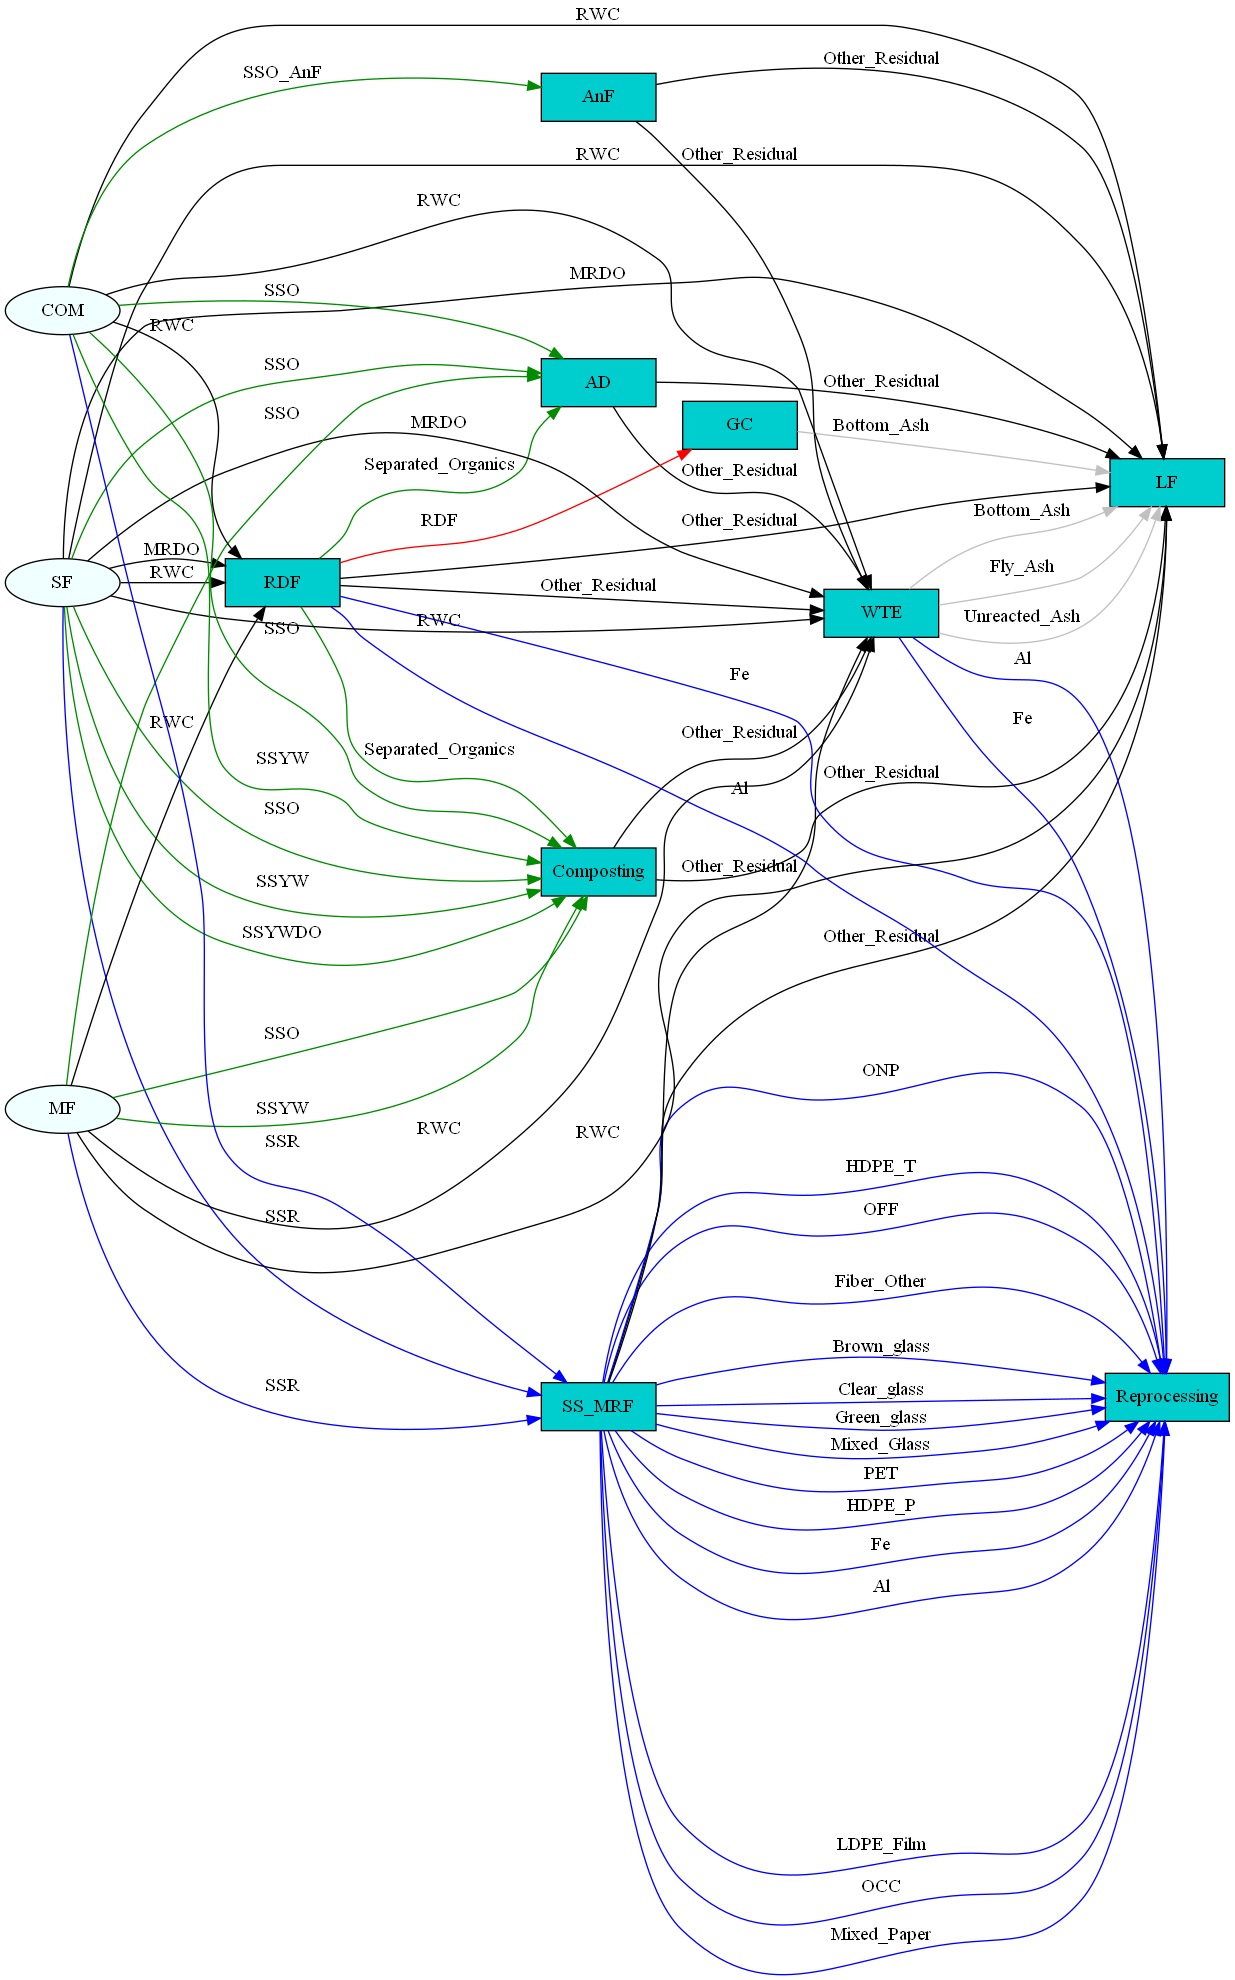

In [17]:
demo.parameters.SWM_network(show_vals=False, all_flow=False, filename='SWM_network_optimization')
Image(filename='SWM_network_optimization.gv.png', width=300)

In [18]:
# Functions used in reporting the optimization results
def Iterations_Performance(OptObject, FileName):
    objectives = []
    times = []
    for res in OptObject.all_results:
        if res:
            if res.success:
                objectives.append(res.fun * 10**OptObject.magnitude)
                times.append(res.time)
            else:
                objectives.append(None)
                times.append(res.time)
        else:
            objectives.append(None)
            times.append(None)

    DF = pd.DataFrame({'Objective': objectives, 'Time': times})
    DF['Ratio'] = DF['Objective']/DF['Objective'].min()
    DF.to_csv(FileName)

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "14"
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15,9), sharex=True)

    DF['Objective'].plot(kind='bar', ax=ax1, color='b')
    ax1.set_ylabel(Opt.method[0][-1])

    DF['Ratio'].plot(kind='bar', ax=ax2, color='r')
    ax2.set_ylabel('Ratio to minimum')

    DF['Time'].plot(kind='bar', ax=ax3, color='g')
    ax3.set_ylabel("Time (sec)")
    ax3.set_xlabel('Iteration')
    
    if len(list(DF.index)) > 20:
        ax3.set_xticks(list(DF.index[::5]))
        ax3.set_xticklabels(list(DF.index)[::5])
    
    return DF

def report_res(Opt, FU, fileName):
    results = pd.DataFrame(columns=['Value', 'Unit'],
                           index=perform_index+process_list,)
    Opt.switch_method(GWP_Method)
    Opt.lcia()
    results.loc['GWP',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg CO2/Mg']

    Opt.switch_method(OptCost_Method)
    Opt.lcia()
    results.loc['Operation Cost',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

    Opt.switch_method(CapCost_Method)
    Opt.lcia()
    results.loc['Capital cost',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

    Opt.switch_method(TotCost_Method)
    Opt.lcia()
    results.loc['Total cost',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

    Opt.switch_method(CED_Method)
    Opt.lcia()
    results.loc['CED',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'MJ eq/Mg']

    Opt.switch_method(ACID_Method)
    Opt.lcia()
    results.loc['Acidification',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg SO2 eq/Mg']

    Opt.switch_method(ETP_Method)
    Opt.lcia()
    results.loc['Eutrophication',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg N eq/Mg']

    Opt.switch_method(SMOG_Method)
    Opt.lcia()
    results.loc['Photochemical smog',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg O3 eq/Mg']

    Opt.switch_method(ETOX_Method)
    Opt.lcia()
    results.loc['Ecotoxicity',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']

    Opt.switch_method(HTOX_Method)
    Opt.lcia()
    results.loc['Human toxicity',:] = [Opt.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']


    for process in process_list:
        results.loc[process,:] = [round(sp.LCA_matrix.LCA_matrix.get_mass_flow(Opt, process)), 'Mg/yr']

    results.loc['Diversion',:] = [(1 - results['Value']['LF'] / float(FU.as_dict()['unit'].split(' ')[0])) * 100, '%']
    
    results.to_csv(fileName)
    return(results)

# Optimization

In [19]:
scenario_name = 'MinGHG-C80'
Opt=sp.Optimization(Demand,[method], demo)

constraints = {}
limit = float(FU.as_dict()['unit'].split(' ')[0]) * 80
constraints[TotCost_Method] = {'limit':limit, 'KeyType':'Impact','ConstType':"<="}

config=Opt.config(demo)
config.iloc[6:, [1, 3, 5]] = 'Fix'
config.iloc[6:8, [5]] = 'Optimize'

# Force Separate collection of Recyclables
for s in config.index:
    if s[2] == 'N/A':
        config.loc[[s], ['SF', 'MF', 'COM']] = 0
        config.loc[[s], ['SF mode', 'MF mode', 'COM mode']] = 'Fix'

# Force Separate collection of organics
# for s in config.index:
#     if s[1] == 'N/A' or s[1] == 'SSYW':
#         config.loc[[s], ['SF', 'MF', 'COM']] = 0
#         config.loc[[s], ['SF mode', 'MF mode', 'COM mode']] = 'Fix'
           
           
Opt.set_config(config)
config

,SF,SF mode,MF,MF mode,COM,COM mode
"(RWC, N/A, N/A)",0.00,Fix,0.00,Fix,0.00,Fix
"(RWC, N/A, SSR)",0.33,Optimize,0.33,Optimize,0.25,Optimize
"(RWC, SSYW, N/A)",0.00,Fix,0.00,Fix,0.00,Fix
"(RWC, SSYW, SSR)",0.33,Optimize,0.33,Optimize,0.25,Optimize
"(RWC, SSO, N/A)",0.00,Fix,0.00,Fix,0.00,Fix
"(RWC, SSO, SSR)",0.33,Optimize,0.33,Optimize,0.25,Optimize
"(RWC, SSO_AnF, N/A)",0.00,Fix,0.00,Fix,0.00,Fix
"(RWC, SSO_AnF, SSR)",0.00,Fix,0.00,Fix,0.25,Optimize
"(REC_WetRes, N/A, REC_WetRes)",0.00,Fix,0.00,Fix,0.00,Fix
"(REC_WetRes, SSYW, REC_WetRes)",0.00,Fix,0.00,Fix,0.00,Fix


In [20]:
start = time()
sp.Optimization.multi_start_optimization(Opt, constraints=constraints, collection=True,
                                         n_iter=n_iter, nproc=n_proc, timeout=timeout, initialize_guess=iter_mehtod)
total_time = round(time()-start)
print("Time for Optimization: {} second".format(total_time))
all_results = Opt.all_results



                      Iteration: 0
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58247982.11554684
                      Global min: 58247982.11554684 

                      


                      Iteration: 1
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 57704164.7697829
                      Global min: 57704164.7697829 

                      


                      Iteration: 2
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58339407.79962995
                      Global min: 57704164.7697829 

                      


                      Iteration: 3
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58538161.212589726
                      Global min: 57704164.7697829 

  

Time for Optimization: 3066 second


### Performance of iterations

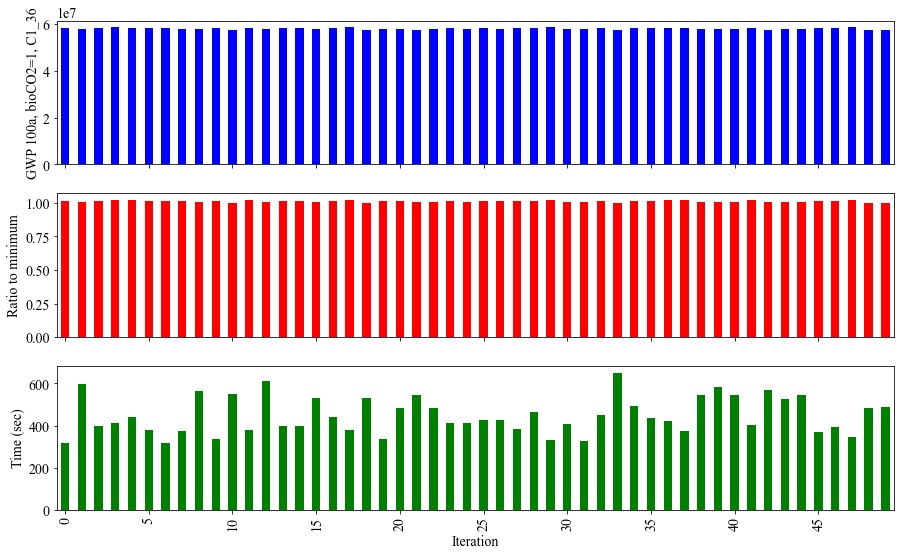

In [21]:
DF = Iterations_Performance(Opt, f'{scenario_name}_Iterations.csv')

## Mass flows, impacts and costs

In [22]:
report_res(Opt, FU, f'{scenario_name}.csv')

,Value,Unit
Diversion,86.58,%
GWP,124.41,kg CO2/Mg
Operation Cost,41.71,$/Mg
Capital cost,38.29,$/Mg
Total cost,80.0,$/Mg
CED,-8298.55,MJ eq/Mg
Acidification,-5.09,kg SO2 eq/Mg
Eutrophication,-1.3,kg N eq/Mg
Photochemical smog,-16.98,kg O3 eq/Mg
Ecotoxicity,-5600.76,CTU/Mg


In [23]:
Opt.switch_method(method)
Opt.lcia()
Opt.plot_sankey(fileName=f'{scenario_name} - 1.html')


              # Sankey Mass flows
              label = ['LF', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing', 'RDF', 'GC', 'WTE', 'SF', 'MF', 'COM']
              source = [1, 1, 2, 2, 3, 3, 4, 4, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 7, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11]
              target = [0, 8, 0, 8, 0, 8, 0, 8, 1, 2, 0, 8, 0, 6, 8, 1, 2, 0, 6, 8, 0, 6, 8, 1, 2, 0, 6, 8, 1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 0, 0, 0, 0, 5, 5, 4, 1, 1, 4, 1, 4, 1, 3]
              label_link = ['Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Separated_Organics', 'Separated_Organics', 'Other_Residual', 'Other_Residual', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'MRDO', 'MRDO', 'MRDO', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'LDPE_Film', 'OCC', 'Mixed_P

In [24]:
params_df = pd.DataFrame(Opt.optimized_x)
for i, j in params_df['name'].items():
    if type(j) == str:
        j = j.strip('frac_of_')
        params_df.loc[i, 'From'] = j.split('_from_')[1].split('_to_')[0]
        params_df.loc[i, 'To'] = j.split('_from_')[1].split('_to_')[1]
        params_df.loc[i, 'Product'] = j.split('_from_')[0]
    else:
        params_df.loc[i, 'From'] = j[0]
        params_df.loc[i, 'Product'] = str(j[1])
params_df[['From', 'To', 'Product', 'amount']]

,From,To,Product,amount
0,Composting,LF,Other_Residual,0.49
1,Composting,WTE,Other_Residual,0.51
2,AD,LF,Other_Residual,0.00
3,AD,WTE,Other_Residual,1.00
4,AnF,LF,Other_Residual,0.00
5,AnF,WTE,Other_Residual,1.00
6,SS_MRF,LF,Other_Residual,0.00
7,SS_MRF,WTE,Other_Residual,1.00
8,RDF,Composting,Separated_Organics,0.67
9,RDF,AD,Separated_Organics,0.33


In [25]:
summary = f"""\n
********  {scenario_name} - Summary *********
Number of decision variables: {len(Opt.optimized_x)}
Number of constraints: {len(Opt._create_constraints())}
Total time: {str(datetime.timedelta(seconds=round(total_time)))}
Average time per iteration: {str(datetime.timedelta(seconds=round(DF['Time'].mean())))}
Successful iterations: {sum(DF['Ratio']>0)}
Number of best iterations: {sum(DF['Ratio']>0.99)}
Number of >95 iterations: {sum(DF['Ratio']>0.95)}\n\n"""
print(summary)
text_file = open("Summary.txt", "a")
text_file.write(summary)
text_file.close()



 collection constraints dict: 
 {'SF': [30, 31, 32], 'MF': [33, 34, 35], 'COM': [36, 37, 38, 39]} 




********  MinGHG-C80 - Summary *********
Number of decision variables: 40
Number of constraints: 17
Total time: 0:51:06
Average time per iteration: 0:07:28
Successful iterations: 50
Number of best iterations: 50
Number of >95 iterations: 50




### Revise RDF composition

In [26]:
## Waste flows to RDF
Mass_to_RDF = sp.LCA_matrix.LCA_matrix.get_mass_flow_comp(Opt, 'RDF', index=common_data.Index)
Mass_to_RDF.head()

Yard_Trimmings_Leaves       9907.19 
Yard_Trimmings_Grass        23695.84
Yard_Trimmings_Branches     13859.36
Food_Waste_Vegetable        36287.33
Food_Waste_Non_Vegetable    18143.66
dtype: float64

In [27]:
## Conversion rate to RDF
Conv_to_RDF = pd.DataFrame(Opt.project.Treatment_processes['RDF']['model'].report()['Waste']).T['RDF']
Conv_to_RDF.head()

Yard_Trimmings_Leaves       1.00
Yard_Trimmings_Grass        0.86
Yard_Trimmings_Branches     0.84
Food_Waste_Vegetable        0.86
Food_Waste_Non_Vegetable    0.91
Name: RDF, dtype: float64

<AxesSubplot:>

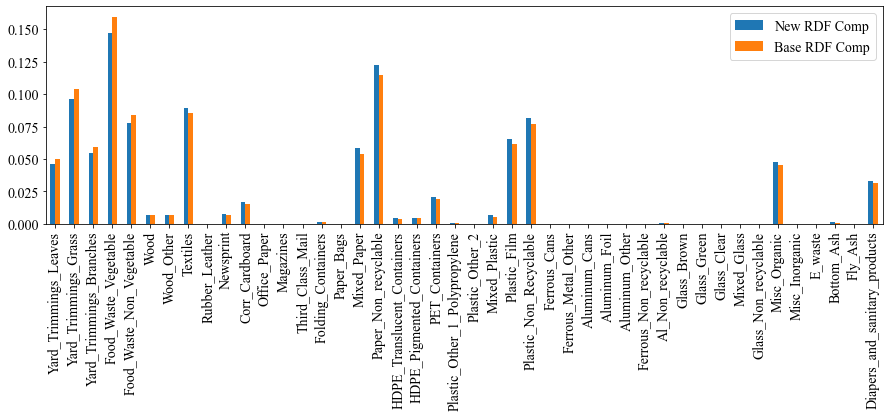

In [28]:
## Calculate composition of RDF
RDF_Mass = Mass_to_RDF * Conv_to_RDF
RDF_Comp = pd.DataFrame(RDF_Mass/RDF_Mass.sum(), columns=['New RDF Comp'])
RDF_Comp['Base RDF Comp'] = Opt.project.Treatment_processes['GC']['model'].process_data['Assumed_Comp']
RDF_Comp[['New RDF Comp']].to_csv(f'{scenario_name}_RDF_Comp.csv')
RDF_Comp.plot.bar(figsize=(15,4))

In [29]:
Opt.project.Treatment_processes['GC']['model'].process_data['Assumed_Comp'] = RDF_Comp
Opt.project.Treatment_processes['GC']['model'].calc()
GC_report = Opt.project.Treatment_processes['GC']['model'].report()
Opt.update_techmatrix(process_name='GC',
                      report_dict=GC_report,
                      tech_matrix=Opt.tech_matrix)
Opt.update_biomatrix(process_name='GC',
                      report_dict=GC_report,
                      bio_matrix=Opt.bio_matrix)

xx = [x['amount'] for x in Opt.optimized_x]
Opt.oldx = [0 for i in range(len(xx))]
Opt._objective_function(xx) * 10**Opt.magnitude

58881634.50048432

In [30]:
start = time()
sp.Optimization.multi_start_optimization(Opt, constraints=constraints, collection=True,
                                         n_iter=8, nproc=n_proc, timeout=timeout, initialize_guess=iter_mehtod)
total_time = round(time()-start)
print("Time for Optimization: {} second".format(total_time))
all_results = Opt.all_results



                      Iteration: 0
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58484367.7880021
                      Global min: 58484367.7880021 

                      


                      Iteration: 1
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58484381.88712157
                      Global min: 58484367.7880021 

                      


                      Iteration: 2
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58927260.08960253
                      Global min: 58484367.7880021 

                      


                      Iteration: 3
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58484361.67067901
                      Global min: 58484361.67067901 

   

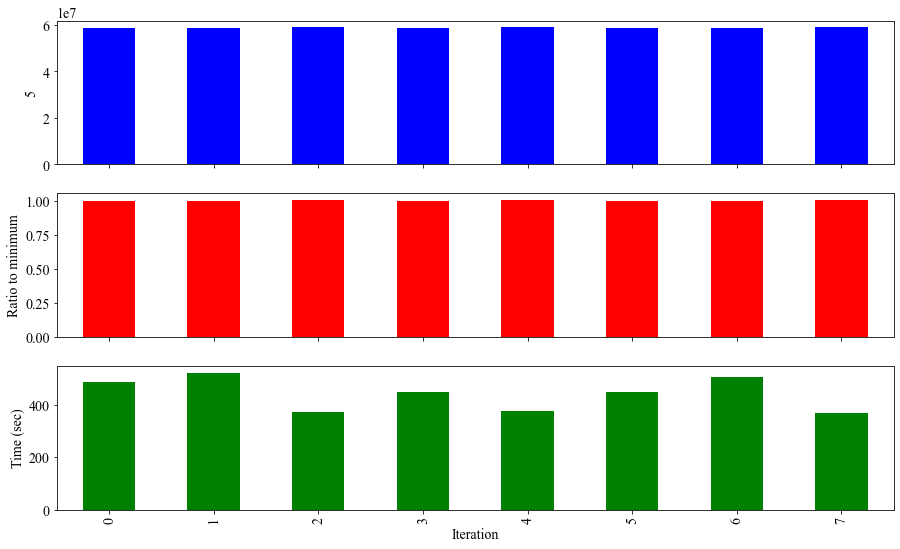

In [31]:
DF = Iterations_Performance(Opt, f'{scenario_name}_Iterations.csv')

In [32]:
params_df = pd.DataFrame(Opt.optimized_x)
for i, j in params_df['name'].items():
    if type(j) == str:
        j = j.strip('frac_of_')
        params_df.loc[i, 'From'] = j.split('_from_')[1].split('_to_')[0]
        params_df.loc[i, 'To'] = j.split('_from_')[1].split('_to_')[1]
        params_df.loc[i, 'Product'] = j.split('_from_')[0]
    else:
        params_df.loc[i, 'From'] = j[0]
        params_df.loc[i, 'Product'] = str(j[1])
params_df[['From', 'To', 'Product', 'amount']]

,From,To,Product,amount
0,Composting,LF,Other_Residual,0.09
1,Composting,WTE,Other_Residual,0.91
2,AD,LF,Other_Residual,0.00
3,AD,WTE,Other_Residual,1.00
4,AnF,LF,Other_Residual,0.00
5,AnF,WTE,Other_Residual,1.00
6,SS_MRF,LF,Other_Residual,0.00
7,SS_MRF,WTE,Other_Residual,1.00
8,RDF,Composting,Separated_Organics,0.13
9,RDF,AD,Separated_Organics,0.87


In [33]:
report_res(Opt, FU, f'{scenario_name}.csv')

,Value,Unit
Diversion,86.5,%
GWP,126.76,kg CO2/Mg
Operation Cost,41.49,$/Mg
Capital cost,38.51,$/Mg
Total cost,80.0,$/Mg
CED,-8410.75,MJ eq/Mg
Acidification,-5.12,kg SO2 eq/Mg
Eutrophication,-1.3,kg N eq/Mg
Photochemical smog,-16.81,kg O3 eq/Mg
Ecotoxicity,-5617.79,CTU/Mg


In [34]:
Opt.switch_method(method)
Opt.lcia()
Opt.plot_sankey(fileName=f'{scenario_name} - 2.html')


              # Sankey Mass flows
              label = ['LF', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing', 'RDF', 'GC', 'WTE', 'SF', 'MF', 'COM']
              source = [1, 1, 2, 2, 3, 3, 4, 4, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 7, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11]
              target = [0, 8, 0, 8, 0, 8, 0, 8, 1, 2, 0, 8, 0, 6, 8, 1, 2, 0, 6, 8, 0, 6, 8, 1, 2, 0, 6, 8, 1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 0, 0, 0, 0, 5, 5, 4, 1, 1, 4, 1, 4, 1, 3]
              label_link = ['Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Separated_Organics', 'Separated_Organics', 'Other_Residual', 'Other_Residual', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'MRDO', 'MRDO', 'MRDO', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'LDPE_Film', 'OCC', 'Mixed_P

In [35]:
Opt.optimized_x

[{'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 0.0934},
 {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 0.9066},
 {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_Other_Residual_from_AnF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_AnF_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_Composting',
  'amount': 0.1315},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_AD', 'amount': 0.8685},
 {'name': 'frac_of_Other_Residual_from_RDF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_RDF_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_RWC_from_SF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_RWC_from_SF_to_RDF', 'amount': 0.8075},
 {'name': 'frac_of_RWC_from_S

### Revise RDF composition  2nd time

In [36]:
## Waste flows to RDF
Mass_to_RDF = sp.LCA_matrix.LCA_matrix.get_mass_flow_comp(Opt, 'RDF', index=common_data.Index)
Mass_to_RDF.head()

Yard_Trimmings_Leaves       10011.82
Yard_Trimmings_Grass        23957.41
Yard_Trimmings_Branches     14016.30
Food_Waste_Vegetable        35695.54
Food_Waste_Non_Vegetable    17847.77
dtype: float64

<AxesSubplot:>

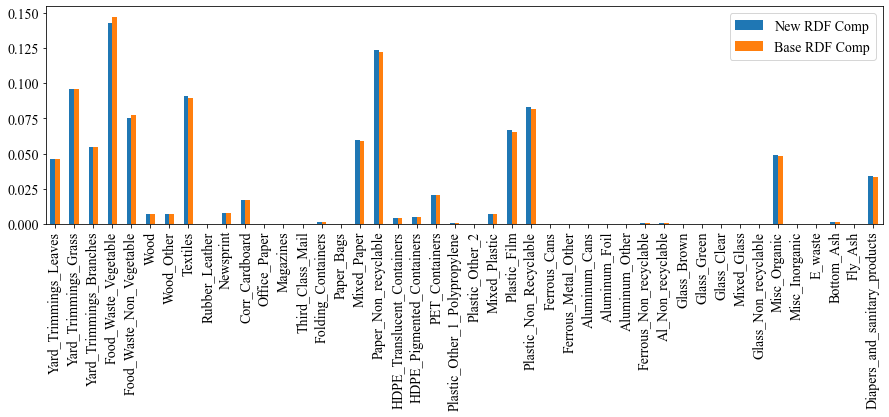

In [37]:
## Calculate composition of RDF
RDF_Mass = Mass_to_RDF * Conv_to_RDF
RDF_Comp = pd.DataFrame(RDF_Mass/RDF_Mass.sum(), columns=['New RDF Comp'])
RDF_Comp['Base RDF Comp'] = Opt.project.Treatment_processes['GC']['model'].process_data['Assumed_Comp']
RDF_Comp[['New RDF Comp']].to_csv(f'{scenario_name}_RDF_Comp.csv')
RDF_Comp.plot.bar(figsize=(15,4))

In [38]:
Opt.project.Treatment_processes['GC']['model'].process_data['Assumed_Comp'] = RDF_Comp
Opt.project.Treatment_processes['GC']['model'].calc()
GC_report = Opt.project.Treatment_processes['GC']['model'].report()
Opt.update_techmatrix(process_name='GC',
                      report_dict=GC_report,
                      tech_matrix=Opt.tech_matrix)
Opt.update_biomatrix(process_name='GC',
                      report_dict=GC_report,
                      bio_matrix=Opt.bio_matrix)

xx = [x['amount'] for x in Opt.optimized_x]
Opt.oldx = [0 for i in range(len(xx))]
Opt._objective_function(xx) * 10**Opt.magnitude

58859540.84001061

In [39]:
start = time()
sp.Optimization.multi_start_optimization(Opt, constraints=constraints, collection=True,
                                         n_iter=8, nproc=n_proc, timeout=timeout, initialize_guess=iter_mehtod)
total_time = round(time()-start)
print("Time for Optimization: {} second".format(total_time))
all_results = Opt.all_results



                      Iteration: 0
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58796746.34514677
                      Global min: 58796746.34514677 

                      


                      Iteration: 1
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58796752.57060731
                      Global min: 58796746.34514677 

                      


                      Iteration: 2
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58796750.55748001
                      Global min: 58796746.34514677 

                      


                      Iteration: 3
                      Status: False, Message: Positive directional derivative for linesearch
                      Objective function: 59251061.4210577
                      Global min: 58796746.

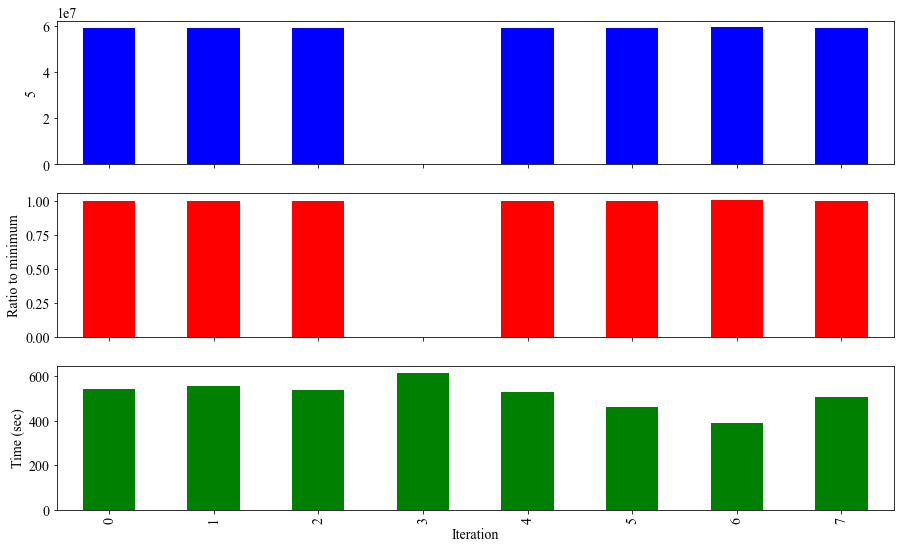

In [40]:
DF = Iterations_Performance(Opt, f'{scenario_name}_Iterations.csv')

In [41]:
params_df = pd.DataFrame(Opt.optimized_x)
for i, j in params_df['name'].items():
    if type(j) == str:
        j = j.strip('frac_of_')
        params_df.loc[i, 'From'] = j.split('_from_')[1].split('_to_')[0]
        params_df.loc[i, 'To'] = j.split('_from_')[1].split('_to_')[1]
        params_df.loc[i, 'Product'] = j.split('_from_')[0]
    else:
        params_df.loc[i, 'From'] = j[0]
        params_df.loc[i, 'Product'] = str(j[1])
params_df[['From', 'To', 'Product', 'amount']]

,From,To,Product,amount
0,Composting,LF,Other_Residual,0.68
1,Composting,WTE,Other_Residual,0.32
2,AD,LF,Other_Residual,0.00
3,AD,WTE,Other_Residual,1.00
4,AnF,LF,Other_Residual,0.00
5,AnF,WTE,Other_Residual,1.00
6,SS_MRF,LF,Other_Residual,0.00
7,SS_MRF,WTE,Other_Residual,1.00
8,RDF,Composting,Separated_Organics,0.25
9,RDF,AD,Separated_Organics,0.75


In [42]:
report_res(Opt, FU, f'{scenario_name}.csv')

,Value,Unit
Diversion,86.47,%
GWP,127.43,kg CO2/Mg
Operation Cost,41.45,$/Mg
Capital cost,38.55,$/Mg
Total cost,80.0,$/Mg
CED,-8443.15,MJ eq/Mg
Acidification,-5.14,kg SO2 eq/Mg
Eutrophication,-1.31,kg N eq/Mg
Photochemical smog,-16.85,kg O3 eq/Mg
Ecotoxicity,-5622.82,CTU/Mg


In [43]:
Opt.switch_method(method)
Opt.lcia()
Opt.plot_sankey(fileName=f'{scenario_name} - 3.html')


              # Sankey Mass flows
              label = ['LF', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing', 'RDF', 'GC', 'WTE', 'SF', 'MF', 'COM']
              source = [1, 1, 2, 2, 3, 3, 4, 4, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 7, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11]
              target = [0, 8, 0, 8, 0, 8, 0, 8, 1, 2, 0, 8, 0, 6, 8, 1, 2, 0, 6, 8, 0, 6, 8, 1, 2, 0, 6, 8, 1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 0, 0, 0, 0, 5, 5, 4, 1, 1, 4, 1, 4, 1, 3]
              label_link = ['Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Separated_Organics', 'Separated_Organics', 'Other_Residual', 'Other_Residual', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'MRDO', 'MRDO', 'MRDO', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'LDPE_Film', 'OCC', 'Mixed_P

In [44]:
Opt.optimized_x

[{'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 0.6794},
 {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 0.3206},
 {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_Other_Residual_from_AnF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_AnF_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_Composting',
  'amount': 0.2452},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_AD', 'amount': 0.7548},
 {'name': 'frac_of_Other_Residual_from_RDF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_RDF_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_RWC_from_SF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_RWC_from_SF_to_RDF', 'amount': 0.8131},
 {'name': 'frac_of_RWC_from_S

In [45]:
params_df = pd.DataFrame(Opt.optimized_x)
for i, j in params_df['name'].items():
    if type(j) == str:
        j = j.strip('frac_of_')
        params_df.loc[i, 'From'] = j.split('_from_')[1].split('_to_')[0]
        params_df.loc[i, 'To'] = j.split('_from_')[1].split('_to_')[1]
        params_df.loc[i, 'Product'] = j.split('_from_')[0]
    else:
        params_df.loc[i, 'From'] = j[0]
        params_df.loc[i, 'Product'] = str(j[1])
params_df[['From', 'To', 'Product', 'amount']]

,From,To,Product,amount
0,Composting,LF,Other_Residual,0.68
1,Composting,WTE,Other_Residual,0.32
2,AD,LF,Other_Residual,0.00
3,AD,WTE,Other_Residual,1.00
4,AnF,LF,Other_Residual,0.00
5,AnF,WTE,Other_Residual,1.00
6,SS_MRF,LF,Other_Residual,0.00
7,SS_MRF,WTE,Other_Residual,1.00
8,RDF,Composting,Separated_Organics,0.25
9,RDF,AD,Separated_Organics,0.75


### Revise RDF composition  3rd time

In [46]:
## Waste flows to RDF
Mass_to_RDF = sp.LCA_matrix.LCA_matrix.get_mass_flow_comp(Opt, 'RDF', index=common_data.Index)
Mass_to_RDF.head()

Yard_Trimmings_Leaves       10075.88
Yard_Trimmings_Grass        24117.56
Yard_Trimmings_Branches     14112.40
Food_Waste_Vegetable        35887.24
Food_Waste_Non_Vegetable    17943.62
dtype: float64

<AxesSubplot:>

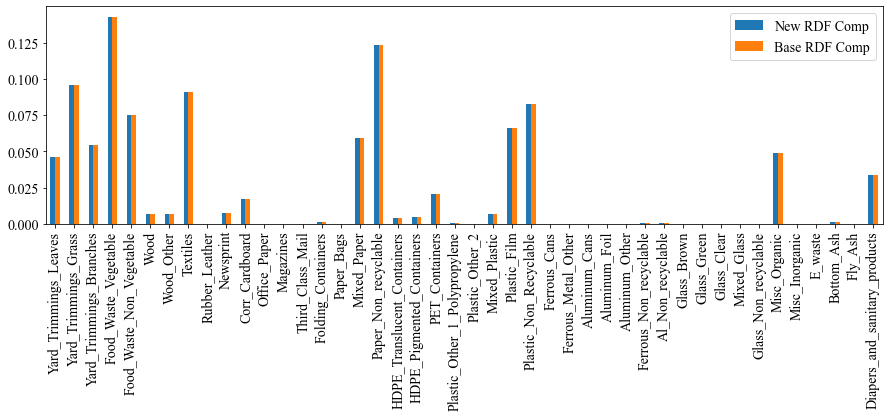

In [47]:
## Calculate composition of RDF
RDF_Mass = Mass_to_RDF * Conv_to_RDF
RDF_Comp = pd.DataFrame(RDF_Mass/RDF_Mass.sum(), columns=['New RDF Comp'])
RDF_Comp['Base RDF Comp'] = Opt.project.Treatment_processes['GC']['model'].process_data['Assumed_Comp']
RDF_Comp[['New RDF Comp']].to_csv(f'{scenario_name}_RDF_Comp.csv')
RDF_Comp.plot.bar(figsize=(15,4))

In [48]:
Opt.project.Treatment_processes['GC']['model'].process_data['Assumed_Comp'] = RDF_Comp
Opt.project.Treatment_processes['GC']['model'].calc()
GC_report = Opt.project.Treatment_processes['GC']['model'].report()
Opt.update_techmatrix(process_name='GC',
                      report_dict=GC_report,
                      tech_matrix=Opt.tech_matrix)
Opt.update_biomatrix(process_name='GC',
                      report_dict=GC_report,
                      bio_matrix=Opt.bio_matrix)

xx = [x['amount'] for x in Opt.optimized_x]
Opt.oldx = [0 for i in range(len(xx))]
Opt._objective_function(xx) * 10**Opt.magnitude

58782957.49454718

In [49]:
start = time()
sp.Optimization.multi_start_optimization(Opt, constraints=constraints, collection=True,
                                         n_iter=8, nproc=n_proc, timeout=timeout, initialize_guess=iter_mehtod)
total_time = round(time()-start)
print("Time for Optimization: {} second".format(total_time))
all_results = Opt.all_results



                      Iteration: 0
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58786147.823668286
                      Global min: 58786147.823668286 

                      


                      Iteration: 1
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58786156.05965314
                      Global min: 58786147.823668286 

                      


                      Iteration: 2
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 59240074.90234741
                      Global min: 58786147.823668286 

                      


                      Iteration: 3
                      Status: True, Message: Optimization terminated successfully
                      Objective function: 58786157.62149791
                      Global min: 58786147.823668

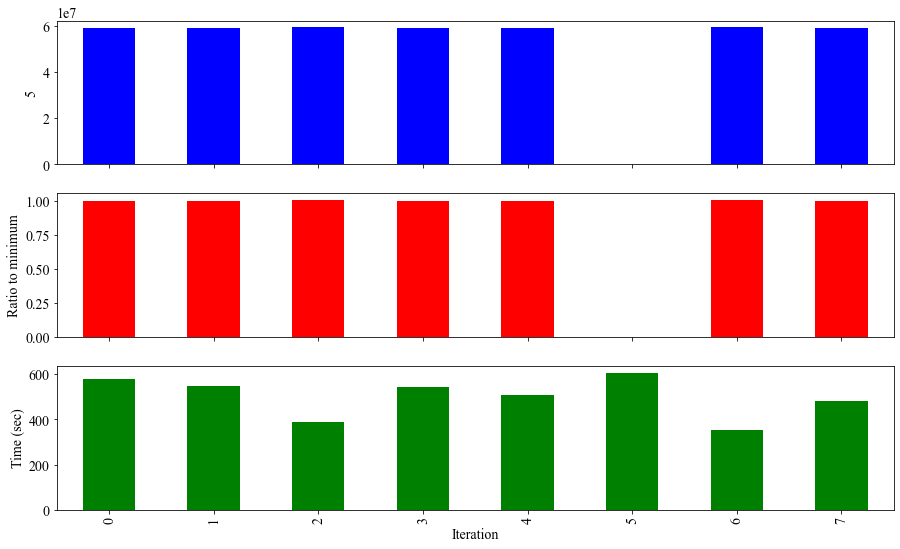

In [50]:
DF = Iterations_Performance(Opt, f'{scenario_name}_Iterations.csv')

In [51]:
params_df = pd.DataFrame(Opt.optimized_x)
for i, j in params_df['name'].items():
    if type(j) == str:
        j = j.strip('frac_of_')
        params_df.loc[i, 'From'] = j.split('_from_')[1].split('_to_')[0]
        params_df.loc[i, 'To'] = j.split('_from_')[1].split('_to_')[1]
        params_df.loc[i, 'Product'] = j.split('_from_')[0]
    else:
        params_df.loc[i, 'From'] = j[0]
        params_df.loc[i, 'Product'] = str(j[1])
params_df[['From', 'To', 'Product', 'amount']]

,From,To,Product,amount
0,Composting,LF,Other_Residual,0.13
1,Composting,WTE,Other_Residual,0.87
2,AD,LF,Other_Residual,0.00
3,AD,WTE,Other_Residual,1.00
4,AnF,LF,Other_Residual,0.00
5,AnF,WTE,Other_Residual,1.00
6,SS_MRF,LF,Other_Residual,0.00
7,SS_MRF,WTE,Other_Residual,1.00
8,RDF,Composting,Separated_Organics,0.38
9,RDF,AD,Separated_Organics,0.62


In [52]:
report_res(Opt, FU, f'{scenario_name}.csv')

,Value,Unit
Diversion,86.47,%
GWP,127.41,kg CO2/Mg
Operation Cost,41.46,$/Mg
Capital cost,38.54,$/Mg
Total cost,80.0,$/Mg
CED,-8441.6,MJ eq/Mg
Acidification,-5.14,kg SO2 eq/Mg
Eutrophication,-1.31,kg N eq/Mg
Photochemical smog,-16.85,kg O3 eq/Mg
Ecotoxicity,-5622.57,CTU/Mg


In [53]:
Opt.switch_method(method)
Opt.lcia()
Opt.plot_sankey(fileName=f'{scenario_name} - 4.html')


              # Sankey Mass flows
              label = ['LF', 'Composting', 'AD', 'AnF', 'SS_MRF', 'Reprocessing', 'RDF', 'GC', 'WTE', 'SF', 'MF', 'COM']
              source = [1, 1, 2, 2, 3, 3, 4, 4, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 7, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11]
              target = [0, 8, 0, 8, 0, 8, 0, 8, 1, 2, 0, 8, 0, 6, 8, 1, 2, 0, 6, 8, 0, 6, 8, 1, 2, 0, 6, 8, 1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 0, 0, 0, 0, 5, 5, 4, 1, 1, 4, 1, 4, 1, 3]
              label_link = ['Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Other_Residual', 'Separated_Organics', 'Separated_Organics', 'Other_Residual', 'Other_Residual', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'MRDO', 'MRDO', 'MRDO', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'RWC', 'RWC', 'RWC', 'SSO', 'SSO', 'LDPE_Film', 'OCC', 'Mixed_P

In [54]:
Opt.optimized_x

[{'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 0.1259},
 {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 0.8741},
 {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_Other_Residual_from_AnF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_AnF_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_Composting',
  'amount': 0.3795},
 {'name': 'frac_of_Separated_Organics_from_RDF_to_AD', 'amount': 0.6205},
 {'name': 'frac_of_Other_Residual_from_RDF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_Other_Residual_from_RDF_to_WTE', 'amount': 1.0},
 {'name': 'frac_of_RWC_from_SF_to_LF', 'amount': 0.0},
 {'name': 'frac_of_RWC_from_SF_to_RDF', 'amount': 0.8128},
 {'name': 'frac_of_RWC_from_S

In [55]:
params_df = pd.DataFrame(Opt.optimized_x)
for i, j in params_df['name'].items():
    if type(j) == str:
        j = j.strip('frac_of_')
        params_df.loc[i, 'From'] = j.split('_from_')[1].split('_to_')[0]
        params_df.loc[i, 'To'] = j.split('_from_')[1].split('_to_')[1]
        params_df.loc[i, 'Product'] = j.split('_from_')[0]
    else:
        params_df.loc[i, 'From'] = j[0]
        params_df.loc[i, 'Product'] = str(j[1])
params_df[['From', 'To', 'Product', 'amount']]

,From,To,Product,amount
0,Composting,LF,Other_Residual,0.13
1,Composting,WTE,Other_Residual,0.87
2,AD,LF,Other_Residual,0.00
3,AD,WTE,Other_Residual,1.00
4,AnF,LF,Other_Residual,0.00
5,AnF,WTE,Other_Residual,1.00
6,SS_MRF,LF,Other_Residual,0.00
7,SS_MRF,WTE,Other_Residual,1.00
8,RDF,Composting,Separated_Organics,0.38
9,RDF,AD,Separated_Organics,0.62


## Improve/Revise solution

In [56]:
# xx = [x['amount'] for x in Opt.optimized_x]
# Opt.oldx = [0 for i in xx]


# # Revis MF collection: only ('RWC', 'SSO', 'SSR')
# xx[33] = 1
# Opt.optimized_x[33]['amount'] = 1
# xx[35] = 0
# Opt.optimized_x[35]['amount'] = 0
# # Revise Residuals from AD: Only WTE
# # xx[2] = 0
# # Opt.optimized_x[2]['amount'] = 0
# # xx[3] = 1
# # Opt.optimized_x[3]['amount'] = 1


# # Revise Residuals from AnF: Only WTE
# # xx[4] = 0
# # Opt.optimized_x[4]['amount'] = 0
# # xx[5] = 1
# # Opt.optimized_x[5]['amount'] = 1

# Opt.switch_method(method)
# Opt.lcia()

# new_res = Opt._objective_function(xx) * 10**Opt.magnitude
# opt_solution = Opt.res_global['fun'] * 10**Opt.magnitude
# ratio = round(new_res/opt_solution, 5)
# solution_improved = new_res<opt_solution

# print(new_res, new_res<opt_solution, ratio)

In [57]:
# params_df = pd.DataFrame(Opt.optimized_x)
# for i, j in params_df['name'].items():
#     if type(j) == str:
#         j = j.strip('frac_of_')
#         params_df.loc[i, 'From'] = j.split('_from_')[1].split('_to_')[0]
#         params_df.loc[i, 'To'] = j.split('_from_')[1].split('_to_')[1]
#         params_df.loc[i, 'Product'] = j.split('_from_')[0]
#     else:
#         params_df.loc[i, 'From'] = j[0]
#         params_df.loc[i, 'Product'] = str(j[1])
# params_df[['From', 'To', 'Product', 'amount']]

In [58]:
# report_res(Opt, FU, f'{scenario_name}.csv')

In [59]:
# Opt.optimized_x

In [60]:
# Opt.switch_method(method)
# Opt.lcia()
# Opt.plot_sankey(optimized_flow=False, show=True, fileName=f'{scenario_name}.html', params=xx)